# Stock linear regression analysis
Build the linear regression models of stocks to get the coefficients representing trends (class method)

# Part 1:  build functions and test using stock_list_test.txt

In [44]:
import numpy as np
from sklearn import datasets, linear_model
import pandas as pd
import matplotlib.pyplot as pl

#!pip install yfinance

import yfinance as yf
from datetime import date

stock_coefficient_file_name= './../../resources/Stock_Coefficients.csv'

# Considering data from 2000 to till date for latest trend
start = '2018-01-01'
end = date.today().strftime("%Y-%m-%d")


For the consistency of the whole project, read the stock list of all the symbols we needed in the text file.
- The stock_list_test.txt is cutted from the stock_list.txt, and it should be in the same directory as this ipynb file.
- The stock_list.txt is generated from the first part of the project

In [45]:
# function1 to get stock list from text file
def get_list(filename):
    # pandas read file into data frame
    stocks = pd.read_csv(filename, header = None)
    stocks[0] = stocks[0].str.upper()
    # convert the data frame to numpy array
    stock_array = stocks.values
    return stock_array

In [46]:
# function1 using example using stock_list_test.txt
stock_array = get_list('./../../resources/stock_list.txt')
stock_array[:5]


array([['AARTIIND.NS'],
       ['ABBOTINDIA.NS'],
       ['ACC.NS'],
       ['ADANIENT.NS'],
       ['ADANIPORTS.NS']], dtype=object)

For fetching historical data from yahoo finance, an addtional package pandas_datareader are used here, which can be installed with pip from the command line:

pip install pandas-datareader

We can specify the stock symbol, start date, end date and also the data source.

There are three exceptions defined for handling error while fetching data using datareader:
- error RemoteDataError: when the symbol is not valid and can't be find in the dataset
- error KeyError: when there isn't full data for the input data range(start, end)

In [56]:
import pandas_datareader.data as web
from pandas_datareader._utils import RemoteDataError

# Considering data from 2018 to 2019 for latest trend
start = '2018-01-01'
end = '2022-02-01' #date.today().strftime("%Y-%m-%d")

# function2: get historical data for a specific stock, using symbol as the parameter
def load_stock_data(symbol):
    try:

        df = yf.download(symbol , start , end )
        #web.DataReader(symbol, 'yahoo', start, end)
    except RemoteDataError:
        print("No search result : '" + symbol + "'")
        return float('NaN')
    except KeyError:
        print("Date range not supported : '" + symbol + "'")
        return float('NaN')
    close = df[['Close']]
    
    # Normalize close value by divided by the base value (the close price of the earliest day) and multiplied by 100
    base = close.iloc[0]['Close']
    # neglect the stocks the initial close price < 25 USD to insure the selected stock value
    if base > 10 :
        close = close.assign(Close = close['Close'] / base * 100)
    return close

In [57]:
A_close = load_stock_data('RBL.NS')
A_close[:5]

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2018-01-01,100.000000
2018-01-02,99.632443
2018-01-03,101.436014
2018-01-04,100.529956
2018-01-05,100.209415


[*********************100%***********************]  1 of 1 completed


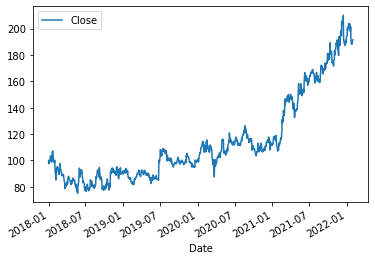

In [58]:
# function2 using example
A_close = load_stock_data('TORNTPOWER.NS')
A_close.plot()
pl.show()

In [59]:
from sklearn.model_selection import train_test_split

# function3: build linear regression model for a specific stock
# parameter 
    # show_statistics: indicate if the statistics are printed 
    # show_dots: indicate if dots data needed
    # show_plot: indacate if the plot is shown

#The coefficient estimates for Ordinary Least Squares rely on the independence of the features. 
#When features are correlated and the columns of the design matrix  have an approximately linear dependence, 
#the design matrix becomes close to singular and as a result, the least-squares estimate becomes highly sensitive to random errors in the observed target, 
#producing a large variance. 
    
def build_linear_regression(symbol, show_statistics = True, show_dots = True, show_plot = True):
    close = load_stock_data(symbol)
    # if the close is not dataframe, return NaN
    if not isinstance(close, pd.DataFrame) :
        return float('NaN')
    
    # normalize datatime datatype to integer
    # simply converting datetime's to # of days since 2018-04-01 divided by 100
    close.index = (close.index - pd.to_datetime('2019-01-01')).days / 100
    close = close.reset_index()
    train, test= train_test_split(close)
    
    train_x = train.drop('Close', axis = 1)
    train_y = train[['Close']]
    test_x = test.drop('Close', axis = 1)
    test_y = test[['Close']]
    
    #call linear regression model
    regr = linear_model.LinearRegression()
    regr.fit(train_x,train_y)
    
    if show_statistics :
        # The coefficients
        print('Coefficients         ->', regr.coef_[0])
        # The mean squared error
        print("Mean squared error   -> %.2f"
        % np.mean((regr.predict(test_x) - test_y) ** 2))
        # Explained variance score: 1 is perfect prediction
        print('Variance score       -> %.2f' % regr.score(test_x, test_y))
        print('features             ->', 'Date', 'Stock Close Price')
    
    if show_plot :
        pl.plot(test_x, regr.predict(test_x), label = symbol)
        pl.legend()
        
        # Plot outputs
        pl.xlabel('Date')
        pl.ylabel('Close Price')
        pl.title('Overall Linear Regression Model')

        if show_dots :
            #pl.title(symbol + ' Linear Regression Model')
            pl.plot(test['Date'], test['Close'], linestyle='none', marker='o')
    
        pl.xticks(())
        pl.yticks(())
    # return the coefficient representing trend
    return regr.coef_[0][0]

[*********************100%***********************]  1 of 1 completed
Coefficients         -> [1.0050665]
Mean squared error   -> 288.93
Variance score       -> 0.08
features             -> Date Stock Close Price


1.0050665014483393

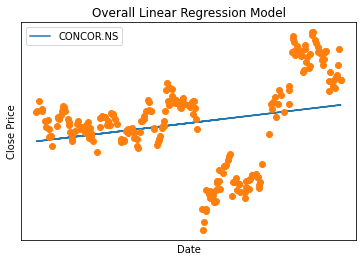

In [60]:
build_linear_regression('CONCOR.NS')

In [61]:
import os


# function4: for each symbol in the text file, caculate the coefficents and record in the original text file
def get_coefficient_dataset(filename, show_statistics = False, show_dots = False, show_plot = False) :
    # load stock list data from text file
    stock_array = get_list(filename)
    # extend the 2D array from N * 1 to N * 2 to make place for putting corresponding coefficient
    stock_array = np.insert(stock_array, 1, values=0, axis=1)

    # caculate coefficient for each symbol and store in the stock_array
    for symbol in stock_array:
        print(symbol)
        coefficient = build_linear_regression(symbol[0], show_statistics, show_dots, show_plot)
        symbol[1] = coefficient
        #break
    
    # transfer stock_array to dataframe with two columns 'Stock' and 'Coefficient'
    coefficient_data = pd.DataFrame(stock_array)
    coefficient_data.columns = ['Stock', 'Coefficient']
    
    # store the dataframe to csv file for future using
    coefficient_data.to_csv(stock_coefficient_file_name)
    return coefficient_data

In [62]:
# function4 using example using stock_list_test.txt
coefficient_data_test = get_coefficient_dataset('./../../resources/stock_list.txt')
coefficient_data_test

['AARTIIND.NS' 0]
[*********************100%***********************]  1 of 1 completed
['ABBOTINDIA.NS' 0]
[*********************100%***********************]  1 of 1 completed
['ACC.NS' 0]
[*********************100%***********************]  1 of 1 completed
['ADANIENT.NS' 0]
[*********************100%***********************]  1 of 1 completed
['ADANIPORTS.NS' 0]
[*********************100%***********************]  1 of 1 completed
['ABFRL.NS' 0]
[*********************100%***********************]  1 of 1 completed
['APLLTD.NS' 0]
[*********************100%***********************]  1 of 1 completed
['ALKEM.NS' 0]
[*********************100%***********************]  1 of 1 completed
['AMARAJABAT.NS' 0]
[*********************100%***********************]  1 of 1 completed
['AMBUJACEM.NS' 0]
[*********************100%***********************]  1 of 1 completed
['APOLLOHOSP.NS' 0]
[*********************100%***********************]  1 of 1 completed
['APOLLOTYRE.NS' 0]
[*********************100%*

,Stock,Coefficient
0,AARTIIND.NS,17.185311
1,ABBOTINDIA.NS,18.740992
2,ACC.NS,2.644753
3,ADANIENT.NS,115.821277
4,ADANIPORTS.NS,6.350066
...,...,...
173,VEDL.NS,0.321134
174,IDEA.NS,-3.447122
175,VOLTAS.NS,6.597095
176,WIPRO.NS,11.893548


In [32]:
# function5 to get top n stocks with biggest coefficients
def get_top_stock(coefficient_data, n = 5, show_dots = False) :
    # sort stocks by coefficients with descending order
    top_stocks = coefficient_data.sort_values(by = ['Coefficient'], ascending = False)
    # take top n stocks
    top_stocks = top_stocks[:n]
    top_stocks_list = top_stocks['Stock'].tolist()
    # plot stocks
    for symbol in top_stocks_list:
        build_linear_regression(symbol, show_statistics = False, show_dots = show_dots, show_plot = True)
    # print stock list    
    print("The " + str(n) +" stocks with best trends are: ")
    print(top_stocks['Stock'].tolist())
    return top_stocks

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
The 5 stocks with best trends are: 
['ADANIENT.NS', 'INDIAMART.NS', 'DEEPAKNTR.NS', 'IRCTC.NS', 'COFORGE.NS']


,Stock,Coefficient
3,ADANIENT.NS,113.13193
84,INDIAMART.NS,66.54931
49,DEEPAKNTR.NS,64.641476
87,IRCTC.NS,54.489549
41,COFORGE.NS,43.986951


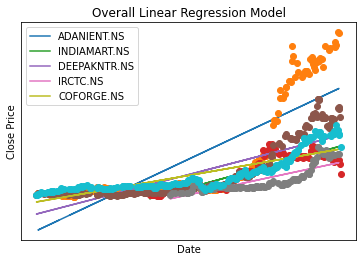

In [33]:
# function5 using example with coefficient_data_test
get_top_stock(coefficient_data_test, n = 5, show_dots = True)

In [35]:
# Function6 to get stocks with same trends
def get_similar_stock(coefficient_data, symbol, n = 3, show_dots = False):
    # sort stocks by coefficients with descending order
    top_stocks = coefficient_data.sort_values(by = ['Coefficient'], ascending = False)
    # get the specific row of the stcok symbol
    row = top_stocks.loc[top_stocks['Stock'] == symbol].iloc[-1]
    # get the offset in the column of that row in the sorted table
    offset = top_stocks.index.get_loc(row.name)
    
    # take similar stocks in the table from offset-3 to offset+3
    similar_stocks = top_stocks[offset-n : offset+n]
    similar_stocks_list = similar_stocks['Stock'].tolist()
    # plot stocks
    for symbol in similar_stocks_list:
        build_linear_regression(symbol, show_statistics = False, show_dots = show_dots, show_plot = True)
        
    # remove the row for the input symbol
    similar_stocks_delete = similar_stocks.drop(row.name)
    number = n*2 - 1
    print("The " + str(number) + " simialr stocks are: ")
    print(similar_stocks_delete['Stock'].tolist())
    return similar_stocks

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
The 5 simialr stocks are: 
['HDFC.NS', 'BRITANNIA.NS', 'GRASIM.NS', 'BIOCON.NS', 'UPL.NS']


,Stock,Coefficient
73,HDFC.NS,3.582119
33,BRITANNIA.NS,3.399329
66,GRASIM.NS,3.240559
148,SBIN.NS,3.237737
31,BIOCON.NS,3.192006
172,UPL.NS,3.145499


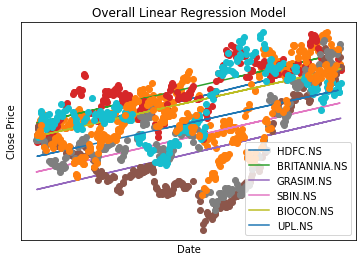

In [40]:
# function6 using example with coefficient_data_test
get_similar_stock(coefficient_data_test, 'SBIN.NS', n = 3, show_dots = True)

# Part 2:  Get project result from stock_list.txt
The stock_list.txt is generated from the first part of the project, and it should be in the same directory as this ipynb file.

- The input is stock_list.txt
- The output is Stock_Coefficients.csv

# Setting: date range for fetching stock historial data
Input: stock_list.txt

# Result 1: Coefficient dataset and export file
Output: Stock_Coefficients.csv

In [37]:
# load full stock_list getting from part1 of this project(association rule)
# error will be printed with invaild symbol name or date keys
# generate output as file Stock_Coefficients.csv


# coefficient_data = get_coefficient_dataset('stock_list.txt', show_plot = False)
# coefficient_data.head()

In [38]:
coefficient_data = pd.read_csv(stock_coefficient_file_name)
coefficient_data.head()

,Unnamed: 0,Stock,Coefficient
0,0,AARTIIND.NS,8.112586
1,1,ABBOTINDIA.NS,74.072826
2,2,ACC.NS,14.380127
3,3,ADANIENT.NS,7.582075
4,4,ADANIPORTS.NS,4.852288


# Result 2: Top five stocks

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
The 5 stocks with best trends are: 
['SHREECEM.NS', 'PAGEIND.NS', 'DEEPAKNTR.NS', 'TORNTPHARM.NS', 'ASIANPAINT.NS']


,Unnamed: 0,Stock,Coefficient
144,144,SHREECEM.NS,1083.427186
128,128,PAGEIND.NS,229.693318
49,49,DEEPAKNTR.NS,187.835576
164,164,TORNTPHARM.NS,151.737599
13,13,ASIANPAINT.NS,148.310761


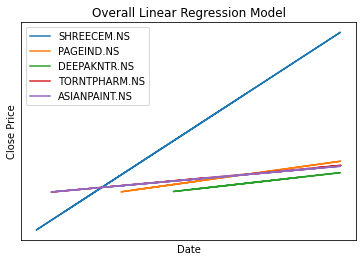

In [39]:
# Get top five stocks from the stock list
get_top_stock(coefficient_data, n = 5)

# Result 3: Similar five stocks for input symbol 'AMZN'

In [40]:
# Get similar five stocks from the stock list, using 'AMZN' as example
# Change it to any input stock symbol
symbol_test = 'GLENMARK.NS'
pd.read_csv("filename.csv")
get_similar_stock(coefficient_data, symbol_test, n = 3)

FileNotFoundError: [Errno 2] No such file or directory: 'filename.csv'

In [ ]:
build_linear_regression('SBIN.NS')

In [80]:
df = yf.download("SBIN.NS" , start , end )

[*********************100%***********************]  1 of 1 completed


In [73]:
df = df.reset_index()

In [74]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

<AxesSubplot:>

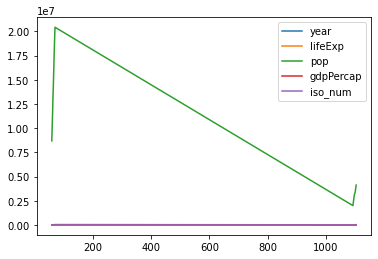

In [79]:
df.plot()

<AxesSubplot:xlabel='year,month'>

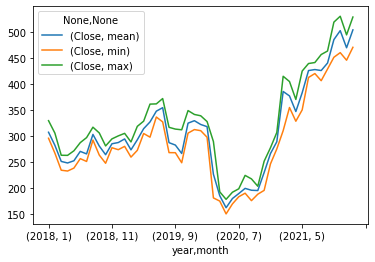

In [76]:
df2 = df.groupby(['year','month']).agg({'Close': ['mean', 'min', 'max']})
df2.plot(legend=True)

In [77]:
df2

Close                        
                  mean         min         max
year month                                    
2018 1      307.663637  296.149994  329.899994
     2      282.592104  267.600006  306.049988
     3      251.665788  234.800003  263.500000
     4      248.671426  233.199997  263.299988
     5      252.909090  238.850006  272.049988
     6      270.904763  257.000000  287.700012
     7      266.120457  251.600006  297.399994
     8      303.523812  292.700012  317.399994
     9      281.219443  263.850006  306.350006
     10     264.573810  248.100006  281.399994
     11     285.554999  277.950012  294.950012
     12     287.919997  274.200012  300.700012
2019 1      294.830432  280.600006  305.549988
     2      273.900000  259.950012  289.049988
     3      293.183333  272.950012  319.000000
     4      314.555261  305.250000  329.000000
     5      327.452272  298.250000  361.700012
     6      348.163155  336.899994  362.149994
     7      354.895651  327.549988  372.399994
     8      287.680002  268.549988  317.149994
     9      283.052633  268.399994  313.750000
     10     266.929999  249.100006  312.399994
     11     325.147496  306.000000  349.299988
     12     329.852382  312.799988  341.850006
2020 1      322.582611  310.700012  339.299988
     2      318.442108  298.100006  328.200012
     3      227.097618  181.600006  289.850006
     4      185.833333  175.500000  193.250000
     5      162.755263  150.850006  178.850006
     6      180.377271  170.050003  192.449997
     7      189.928260  183.800003  199.100006
     8      199.885715  190.649994  224.850006
     9      196.304545  176.350006  218.100006
     10     195.764286  188.699997  204.000000
     11     230.344999  196.050003  252.000000
     12     266.772729  246.949997  277.899994
2021 1      289.452501  275.649994  307.250000
     2      385.995001  310.700012  415.200012
     3      377.400001  355.200012  405.049988
     4      347.460523  328.850006  370.649994
     5      383.542500  350.600006  425.200012
     6      426.156820  412.899994  439.649994
     7      428.066665  420.399994  441.549988
     8      426.197622  406.700012  456.950012
     9      440.595238  429.100006  463.700012
     10     485.540004  451.649994  519.150024
     11     502.807503  460.549988  530.450012
     12     469.915216  446.000000  494.700012
2022 1      504.268423  470.799988  528.950012

In [78]:
df = px.data.gapminder().query("continent=='Oceania'")


In [47]:
df

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
60,Australia,Oceania,1952,69.120,8691212,10039.59564,AUS,36
61,Australia,Oceania,1957,70.330,9712569,10949.64959,AUS,36
62,Australia,Oceania,1962,70.930,10794968,12217.22686,AUS,36
63,Australia,Oceania,1967,71.100,11872264,14526.12465,AUS,36
64,Australia,Oceania,1972,71.930,13177000,16788.62948,AUS,36
65,Australia,Oceania,1977,73.490,14074100,18334.19751,AUS,36
66,Australia,Oceania,1982,74.740,15184200,19477.00928,AUS,36
67,Australia,Oceania,1987,76.320,16257249,21888.88903,AUS,36
68,Australia,Oceania,1992,77.560,17481977,23424.76683,AUS,36
69,Australia,Oceania,1997,78.830,18565243,26997.93657,AUS,36


In [58]:
fig = px.line(df2, x="Close", y="year", color='Close')
fig.show()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().